You can use this notebook to write the ML pipeline for the classification of the galaxies in the GALAXYZOO dataset or create a folder with different files associated to the different steps of the ML pipeline.

In [1]:
#Importing libraries

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import Random forest classifiers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Downloading the Galaxy Zoo Dataset

You can find the dataset from the Github repository at the url:



https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/data

---

#### Create a data frame with columns for objid and the corresponding asset_id.  
- asset_id: an integer that corresponds to the filename of the image of a particular galaxy.
- objid is the designation of the galaxy, e.g. galaxy 587722981741363294

In [2]:
from src.get_files import write_file_list

write_file_list(500, overwrite=True)

Using 100 images from each class
Available classes:
	Ei:	 Eliptic galaxies of type i
	S:	 Spiral galaxy
	Er:	 Eliptic galaxies of type r
	Ec:	 Eliptic galaxies of type c
	SB:	 Barred spiral galaxies


In [3]:
import pandas as pd 

# get the objid and corresponding asset_id from gz2_filename_mapping.csv
columns_to_keep = ['objid', 'asset_id']

# Read the selected columns from the file
name_map = pd.read_csv("data/gz2_filename_mapping.csv", usecols=columns_to_keep)

# display the first few rows
# print(name_map.head(5))

#name_map.info()

---

#### Create a data frame with dr7objid and corresponding label. 
- dr7objid gives the galaxy designation same as objid from the previous data frame.
- label correspond to some classification of the galaxy based on its shape and morphology. 

In [4]:
# select columns dr7objid and gz2class from zoo2MainSpecz.csvW
columns_to_keep = ['dr7objid', 'gz2class']

# Read the selected columns from the file
labels = pd.read_csv("data/zoo2MainSpecz.csv", usecols=columns_to_keep)

# change the name of column dr7objid to objid for merging later
labels.rename(columns={'dr7objid':'objid'}, inplace=True)

# display
#print(labels.head(5))

#labels.info()


---

### 1. Convert array of pixels in rows of a tabular dataset,using single pixels as feature columns and the intensities as values measured (Chris)

In [5]:
# load and processing images, convert to grayscale and flattening pixel. 

from src.data_processing import process_image_seq # sequentially load one image ata time 

# Directory containing the images
image_dir = "data/images"

# call the sequential function
image_data = process_image_seq(image_dir)

#display the data frame
#print(image_data.head())
image_data.info()

# Save to CSV
#image_data("image_pixel_data.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 179777 entries, asset_id to 179775
dtypes: int64(1), uint8(179776)
memory usage: 85.7 MB


In [6]:
# Merge labels and name_map dataframes to map asset_id to gz2class
# merge based on objid. use an inner join (only matching rows) 
# since only a subset of points in labels are in name_map, ann inner join 
# will include the rows from name_map that have matching gz2class values
# this will avoid NaNs

labels_mapped = pd.merge(name_map, labels, on='objid', how='inner' ) 


labels_mapped.describe() # should have the same number of rows as the dataframe labels

,objid,asset_id
count,2.435000e+05,243500.000000
mean,5.878182e+17,142391.360846
std,1.824223e+14,81655.120603
min,5.877230e+17,3.000000
25%,5.877327e+17,71992.750000
50%,5.877393e+17,141183.500000
75%,5.877449e+17,213104.250000
max,5.888489e+17,295305.000000


In [7]:
# Merge labels_mapped with image_data to insert gz2class columnt to the latter 
# Merge based on asset_id and use an inner join. image_data which is our 
# main data frame will only have, in general, a subset of data points (galaxies)
# in labels_mapped. 

#merge
galaxy_data = pd.merge(labels_mapped, image_data, on='asset_id', how='inner' ) 

# Move gz2class to the last position to serve as labels
galaxy_data['gz2class'] = galaxy_data.pop('gz2class')  

# print
print(galaxy_data.head(5))

galaxy_data['gz2class'] = galaxy_data['gz2class'].str[:2].replace(r"\bS[a-z]\w*", "S", regex = True)
print(galaxy_data['gz2class'].value_counts())

galaxy_data.info()

                objid  asset_id   0   1   2  3  4  5  6  7  ...  179767  \
0  587722982281052314       203   5   5   5  5  5  5  5  5  ...       2   
1  587722982829130044       785   2   2   2  2  2  3  3  3  ...       5   
2  587722984437579948      1908   6   5   3  1  2  3  5  7  ...       3   
3  587725040628465756      4526  17  15  11  7  4  2  1  1  ...       4   
4  587725074458476803      5311   1   2   4  5  7  8  8  8  ...       3   

   179768  179769  179770  179771  179772  179773  179774  179775  gz2class  
0       3       8      11       9       4       0       1       3        Er  
1       4       5       5       6       6       5       5       4       SBb  
2       2       2       2       1       1       0       0       0      Sc2m  
3       7      11      13       9       8      10      11      10     SBb2t  
4       5       7      11      15      18      17      13       9      Sc2t  

[5 rows x 179779 columns]
gz2class
Er    100
SB    100
S     100
Ei    100
Ec   

In [8]:
from dask import delayed, compute
import os 
from PIL import Image, ImageOps
from numpy import asarray

In [9]:
# parallel implementation of processing the images with DASK

from src.data_processing import process_image_dask

# Directory containing images
image_dir = "data/images"

# Get list of image file paths
image_files = [
    os.path.join(image_dir, f) for f in os.listdir(image_dir)
    if f.endswith(('.png', '.jpg'))
]

# Parallel execution using Dask
delayed_results = [process_image_dask(img) for img in image_files]
results = compute(*delayed_results)

# Filter out failed reads
results = [res for res in results if res is not None]

# Convert to Dask DataFrame
image_names, data = zip(*results)
image_data = pd.DataFrame(data)
image_data.insert(0, "asset_id", image_names)

#print(galaxy_data.head())

#image_data.info()

# Save to CSV
#df.to_csv("image_pixel_data.csv", index=False)
#print("Processing complete. Data saved to 'image_pixel_data.csv'.")


In [10]:
# Merge labels_mapped with image_data to insert gz2class columnt to the latter 
# Merge based on asset_id and use an inner join. image_data which is our 
# main data frame will only have, in general, a subset of data points (galaxies)
# in labels_mapped. 
# convert asset_id values in image_data from object to int64 before mergeing

#merge
galaxy_data = pd.merge(labels_mapped, image_data, on='asset_id', how='inner') 

# Move gz2class to the last position to serve as labels
galaxy_data['gz2class'] = galaxy_data.pop('gz2class')  

# print
print(galaxy_data.head(5))
galaxy_data['gz2class'] = galaxy_data['gz2class'].str[:2].replace(r"\bS[a-z]\w*", "S", regex = True)

print(galaxy_data['gz2class'].value_counts())
print(galaxy_data[galaxy_data['gz2class'] == 'A'])
galaxy_data.info()

                objid  asset_id   0   1   2  3  4  5  6  7  ...  179767  \
0  587722982281052314       203   5   5   5  5  5  5  5  5  ...       2   
1  587722982829130044       785   2   2   2  2  2  3  3  3  ...       5   
2  587722984437579948      1908   6   5   3  1  2  3  5  7  ...       3   
3  587725040628465756      4526  17  15  11  7  4  2  1  1  ...       4   
4  587725074458476803      5311   1   2   4  5  7  8  8  8  ...       3   

   179768  179769  179770  179771  179772  179773  179774  179775  gz2class  
0       3       8      11       9       4       0       1       3        Er  
1       4       5       5       6       6       5       5       4       SBb  
2       2       2       2       1       1       0       0       0      Sc2m  
3       7      11      13       9       8      10      11      10     SBb2t  
4       5       7      11      15      18      17      13       9      Sc2t  

[5 rows x 179779 columns]
gz2class
Er    100
SB    100
S     100
Ei    100
Ec   

---

### 2. Perform EDA and feature preprocessing (Nisha)
#### 2.1 Exploratory Data Analysis (EDA)

In [11]:
# print
#print(galaxy_data.head(4))

print(galaxy_data.shape)  # Check dimensions

galaxy_data.info()# Check data types & missing values

print(galaxy_data.describe())  # Get summary stats

(500, 179779)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 179779 entries, objid to gz2class
dtypes: int64(2), object(1), uint8(179776)
memory usage: 85.7+ MB
              objid       asset_id           0           1          2  \
count  5.000000e+02     500.000000  500.000000  500.000000  500.00000   
mean   5.878096e+17  143714.944000    5.796000    5.802000    5.82200   
std    1.499078e+14   82300.116651    7.762403    8.399756    9.10407   
min    5.877230e+17     203.000000    0.000000    0.000000    0.00000   
25%    5.877327e+17   71165.750000    2.000000    2.000000    2.00000   
50%    5.877394e+17  150039.000000    4.000000    4.000000    4.00000   
75%    5.877454e+17  213364.750000    7.250000    7.000000    7.00000   
max    5.888489e+17  294339.000000   96.000000  100.000000  118.00000   

                3           4           5           6           7  ...  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  ...   

## Adding the symmetry data

For this kind of images we can get the symmetry information given some axis in order to add a new data that can be relevant to the data frame. In the python module named `get_symmetry` inside of the `src/` folder we define a pair of functions that given an array of images and the number of axis of symmetry we compute the differences between the intensity values of each pixel pair.

The process of getting the symmetries is the following one:

1. Get the coordinates of each pixel.
2. Rotate the coordinate system in an angle $ \theta = \dfrac{i * \pi }{n\_axis} $. Where $i$ is a number that goes from 0 to $ \dfrac{n\_axis}{2}$ and $n_axis$ is the number of axis of symmetry
3. Ignore the data that is outside of a circle of radius width of the image and centered in the middle of the image.
4. Split the image in the upper and the lower part, reflect the left part and compute the distance and append to the vector that stores the symmetry values.
5. Split the image in the left and right part, reflect the right part and compute the distance and append to the vector that stores the symmetry values.
6. Repeat until $i = \dfrac{n\_axis}{2}$.
7. Return the vector with the symmetry values.

For instance, an example of the step 5 is showing on the next image:

![images/symmetries.png](images/symmetries.png)

Lower the distance (darker the image) more symmetric the original image.

Then, we have the following code:

In [12]:
# Import the function from the module
from src.get_symmetry import get_all_symmetries

# Get the data related with the pixels
get_images_column = np.linspace(0, 424*424-1, 424*424)
# Reshape the image and assign it to an array
images_array = np.reshape(galaxy_data[get_images_column].to_numpy(), shape = (galaxy_data.shape[0], 424, 424))

In [13]:
%%time
# Chossing the number of axis
axis = 12

# Defining the column names
columns = [f"axis-{i}" for i in range(axis)]

# Getting the data
sym_data = get_all_symmetries(images_array, axis)

CPU times: user 20.3 s, sys: 1.04 ms, total: 20.3 s
Wall time: 20.3 s


In [21]:
# Appending to the data frame
for i in range(axis):
    galaxy_data[columns[i]] = sym_data[:,i]


# Move gz2class to the last position to serve as labels
galaxy_data['gz2class'] = galaxy_data.pop('gz2class')  

galaxy_data[columns].describe()

,axis-0,axis-1,axis-2,axis-3,axis-4,axis-5,axis-6,axis-7,axis-8,axis-9,axis-10,axis-11
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,3.056236,3.059411,3.019115,3.031504,3.029489,3.043425,3.050423,3.023436,3.051278,2.996940,3.021457,2.966805
std,1.219349,1.399745,1.176072,1.418727,1.184985,1.431365,1.268957,1.399372,1.341824,1.342629,1.381333,1.287374
min,1.388411,1.409615,1.421997,1.394196,1.320365,1.308951,1.341252,1.342443,1.314102,1.274753,1.339573,1.314831
25%,2.261877,2.219561,2.231071,2.188006,2.270770,2.207524,2.233400,2.179672,2.227437,2.168403,2.170347,2.163097
50%,2.746131,2.725878,2.759426,2.717496,2.774600,2.738575,2.756249,2.682394,2.724677,2.670240,2.680589,2.626886
75%,3.440977,3.429309,3.404884,3.374815,3.418045,3.387831,3.466775,3.406787,3.485129,3.405029,3.400039,3.338467
max,11.893256,14.051275,10.307138,14.470791,12.565849,14.579849,13.221837,14.378794,13.166991,13.839439,13.234392,13.065459


In [22]:
#print(galaxy_data.head())
#galaxy_data.info

                objid  asset_id   0   1   2  3  4  5  6  7  ...    axis-3  \
0  587722982281052314       203   5   5   5  5  5  5  5  5  ...  2.942490   
1  587722982829130044       785   2   2   2  2  2  3  3  3  ...  3.633872   
2  587722984437579948      1908   6   5   3  1  2  3  5  7  ...  1.607951   
3  587725040628465756      4526  17  15  11  7  4  2  1  1  ...  2.753304   
4  587725074458476803      5311   1   2   4  5  7  8  8  8  ...  4.293838   

     axis-4    axis-5    axis-6    axis-7    axis-8    axis-9   axis-10  \
0  2.935119  2.808261  2.753554  2.739659  2.745350  2.784243  2.963332   
1  3.395815  3.280015  3.004311  2.842921  2.225853  2.084733  2.681587   
2  1.695744  1.595007  1.661879  1.607545  1.651728  1.618186  1.590757   
3  2.572423  2.538270  2.190242  2.180853  1.973678  1.907763  2.345919   
4  4.660639  4.716052  4.679540  4.608674  4.471859  4.438518  4.026961   

    axis-11  gz2class  
0  2.772539        Er  
1  2.611578        SB  
2  1.671413   

<bound method DataFrame.info of                   objid  asset_id   0   1   2   3   4   5   6   7  ...  \
0    587722982281052314       203   5   5   5   5   5   5   5   5  ...   
1    587722982829130044       785   2   2   2   2   2   3   3   3  ...   
2    587722984437579948      1908   6   5   3   1   2   3   5   7  ...   
3    587725040628465756      4526  17  15  11   7   4   2   1   1  ...   
4    587725074458476803      5311   1   2   4   5   7   8   8   8  ...   
..                  ...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ...   
495  588015508216152237    290241   2   1   2   5   9  12  13  12  ...   
496  588015509289828532    292702   5   2   0   0   0   3   4   4  ...   
497  588015509289828556    292704  26  25  23  21  19  17  15  14  ...   
498  588015509811495058    293276   4   4   5   6   8  11  13  14  ...   
499  588015510343843922    294339   1   5   8   7   4   3   4   7  ...   

       axis-3    axis-4    axis-5    axis-6    axis-7    axis-8    axis-9  \
0 

In [24]:
from sklearn.decomposition import PCA

galaxy_data.columns = galaxy_data.columns.astype(str)

# Select only pixel features (exclude first two columns and label)
pixel_data = galaxy_data.iloc[:, 2:-1]  

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)  # Retain 95% of the variance
principal_components = pca.fit_transform(pixel_data)

# Create new dataframe with principal components
galaxy_data_pca = pd.DataFrame(principal_components)

# Reinsert metadata columns
galaxy_data_pca.insert(0, "objid", galaxy_data["objid"])
galaxy_data_pca.insert(1, "asset_id", galaxy_data["asset_id"])
galaxy_data_pca["gz2class"] = galaxy_data["gz2class"]

print(f"Original shape: {galaxy_data.shape}, Reduced shape with PCA: {galaxy_data_pca.shape}")

Original shape: (500, 179791), Reduced shape with PCA: (500, 296)


---

### 5. Check how many clusters can be associated to the data points joint distribution using tSNE or UMAP. 

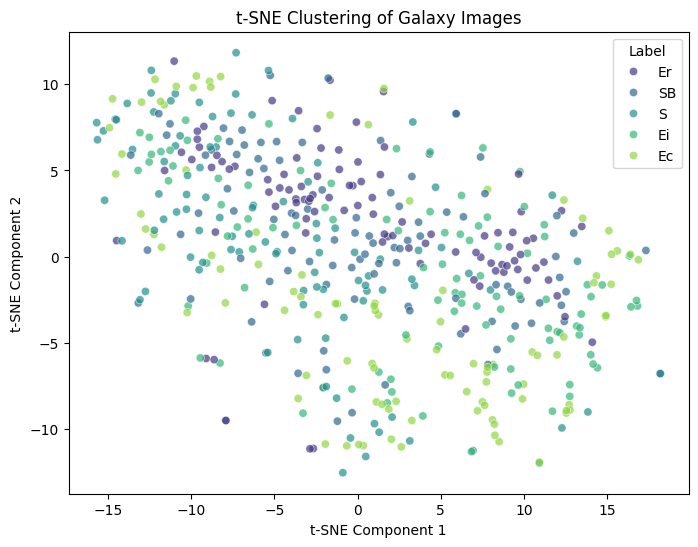

In [25]:
from sklearn.manifold import TSNE

# Convert PCA-reduced data to numpy array (excluding metadata columns)
X_pca = galaxy_data_pca.iloc[:, 2:-1].values  # Excluding "objectid", "asset_id", and "gz2class"

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=galaxy_data_pca["gz2class"], palette="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Clustering of Galaxy Images")
plt.legend(title="Label")
plt.show()

# Utility function to read Images

In [ ]:
#Using PILLOW to convert images to array
from PIL import Image, ImageOps
from numpy import asarray
 
 
# load the image and convert into numpy array
img = Image.open('data/images/6994.jpg') 

img_gray = ImageOps.grayscale(img)

#img_gray.show() #to check it become gray
 
# asarray() class is used to convert
# PIL images into NumPy arraystotal_classifications
numpydata = asarray(img_gray)


# EDA, feature preprocessing and classification

1. Convert array of pixels in rows of a tabular dataset,
   using single pixels as feature columns and the intensities as values measured 
   
   
2. Perform EDA and feature preprocessing

3. Estimate the symmetry of the preprocessed images with respect to 12 axes and add this info to the original data

3. Test how much you can reduce the dimensions of the problem with one algorithm between (PCA, kPCA ..)
4. Check how many clusters can be associated to the data points joint distribution using tSNE or UMAP

5. Build the classifier using Random Forest (play with different  depth and number of trees) or SVC

6. Train the classifier

7. Predict the class labels


# Evaluate the accuracy of the Classifier
## Plot Confusion matrix